**1-**
 Para este paso importé el archivo TiempoDeEntrega. Antes de hacerlo, revisé todas las filas ya que el archivo contenía valores no numéricos en la columna de calificaciones, por lo que decidí eliminar esas filas. Además, detecté la presencia de outliers, como un valor de -100 y otro de 5000 en la columna de horas, los cuales también eliminé por ser inconsistentes con la definición de la variable.

Al analizar el gráfico, observé otros valores poco razonables, por ejemplo tiempos de 200 o 300 horas, lo que implicaría haber entregado una tarea con más de una semana de anticipación. Considerando esto, establecí un criterio de limpieza adicional el cual fue conservar únicamente registros con tiempos menores o iguales a 168 horas (equivalente a una semana). De esta forma eliminé todos los valores fuera de ese rango, quedándome únicamente con datos coherentes.

Con el archivo depurado, importé nuevamente el csv, imprimí las primeras 10 filas para verificar que los datos se cargaran correctamente y finalmente elaboré una gráfica de dispersión para visualizar la relación entre tiempo de entrega y calificación.

      Tiempo  Calificacion
0  85.076389          85.0
1  84.675556          85.0
2  79.553889         110.0
3  75.310556         110.0
4  64.958611         110.0
5  58.157778         110.0
6  56.238611         110.0
7  55.903056         110.0
8  52.465556         103.0
9  51.998333          96.0


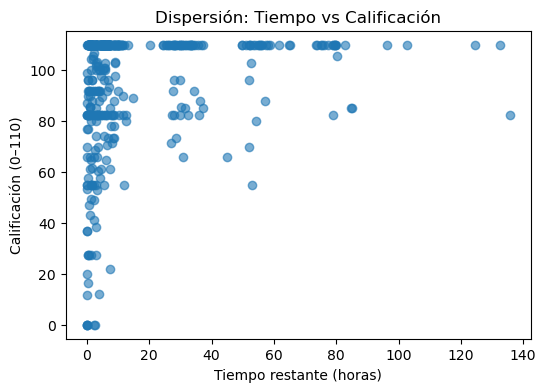

Hipótesis: a menor tiempo restante de entrega, menor calificación; podría requerir modelo no lineal.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("TiempoDeEntrega.csv")
print(df.head(10))

plt.figure(figsize=(6,4))
plt.scatter(df["Tiempo"], df["Calificacion"], alpha=0.6)
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación (0–110)")
plt.title("Dispersión: Tiempo vs Calificación")
plt.show()

print("Hipótesis: a menor tiempo restante de entrega, menor calificación; podría requerir modelo no lineal.")

**2-**
 En este paso dividí mis datos en dos conjuntos, uno de entrenamiento (70% de los registros) y otro de prueba (30% de los registros), utilizando la función *train_test_split*. Para ello tomé como variable independiente (X) el tiempo de entrega y como variable dependiente (y) la calificación. El objetivo de esta división es contar con un conjunto para ajustar los modelos y otro independiente para evaluarlos. Posteriormente, calculé los promedios tanto de Tiempo como de Calificación en cada conjunto. Esta comparación permite verificar que ambos subconjuntos mantengan distribuciones similares, de modo que el análisis no esté sesgado y que el conjunto de prueba sea representativo de los datos originales.

In [5]:
from sklearn.model_selection import train_test_split

X = df[["Tiempo"]].values
y = df["Calificacion"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=21)

print("Promedios en ENTRENAMIENTO:")
print("Tiempo:", X_train.mean())
print("Calificación:", y_train.mean())

print("\nPromedios en PRUEBA:")
print("Tiempo:", X_test.mean())
print("Calificación:", y_test.mean())

Promedios en ENTRENAMIENTO:
Tiempo: 14.49445389263946
Calificación: 94.00845486394557

Promedios en PRUEBA:
Tiempo: 15.692612433801587
Calificación: 96.63853960317459


Los promedios de ambos conjuntos son muy similares.
En el conjunto de entrenamiento el tiempo promedio fue de 14.5 horas y la calificación de 94, mientras que en el conjunto de prueba fueron 15.7 horas y 96.6 respectivamente.
Estas diferencias son pequeñas y no representan un sesgo importante, por lo que ambos conjuntos mantienen una distribución comparable. Esto implica que los modelos que se entrenen con estos datos probablemente tendrán un desempeño representativo y confiable al evaluarse en el conjunto de prueba.

**3-**
 En este paso ajusté una regresión polinomial de grado 2 para modelar la relación entre el tiempo de entrega y la calificación. Primero generé las características polinomiales (Tiempo y Tiempo²) solo con los datos de entrenamiento y añadí una constante para estimar el modelo con OLS (statsmodels). Con el summary() obtuve métricas y coeficientes; además, extraigo explícitamente el término lineal (Tiempo¹) para comentar su signo (si la relación es positiva o negativa) y su significancia estadística (p-valor < 0.05 indica asociación significativa). Luego aplico la misma transformación al conjunto de prueba para obtener las predicciones del polinomio y finalmente grafico una dispersión de los valores reales de prueba y sobre ella la curva polinomial ordenada (línea naranja), lo que permite evaluar visualmente cómo se ajusta el modelo a los datos de validación.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     8.740
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           0.000206
Time:                        04:48:56   Log-Likelihood:                -1349.6
No. Observations:                 294   AIC:                             2705.
Df Residuals:                     291   BIC:                             2716.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.9197      1.858     47.861      0.0

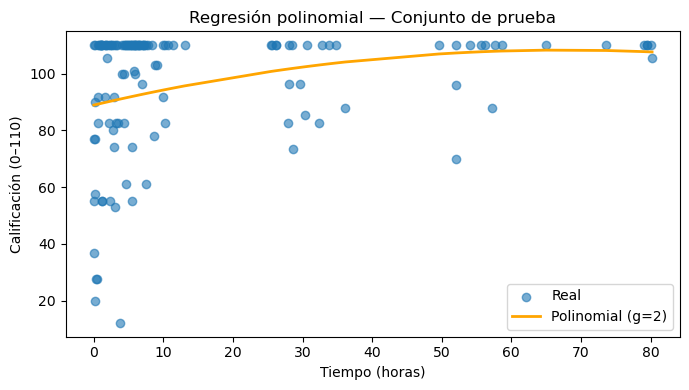

In [7]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)  
X_test_poly  = poly.transform(X_test)     

X_train_poly_sm = sm.add_constant(X_train_poly)
model_poly = sm.OLS(y_train, X_train_poly_sm).fit()
print(model_poly.summary())

coef_names = ["const"] + [f"Tiempo^{i}" for i in range(1, 2+1)]
coefs = dict(zip(coef_names, model_poly.params))
pvals = dict(zip(coef_names, model_poly.pvalues))
coef_lin = coefs["Tiempo^1"]
p_lin = pvals["Tiempo^1"]
sentido = "positiva" if coef_lin > 0 else "negativa"
signif = "significativamente" if p_lin < 0.05 else "no significativamente"

print(f"\nTérmino lineal (Tiempo^1): coef = {coef_lin:.4f}, p-valor = {p_lin:.4g}")

X_test_poly_sm = sm.add_constant(X_test_poly)
yhat_poly = model_poly.predict(X_test_poly_sm)
order = np.argsort(X_test[:, 0])
xt = X_test[order, 0]
yt = y_test[order]
yh = yhat_poly[order]
plt.figure(figsize=(7,4))
plt.scatter(xt, yt, alpha=0.6, label="Real")
plt.plot(xt, yh, linewidth=2, color="orange", label="Polinomial (g=2)")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Calificación (0–110)")
plt.title("Regresión polinomial — Conjunto de prueba")
plt.legend()
plt.tight_layout()
plt.show()

El término lineal muestra una relación positiva (coeficiente = 0.5730), lo que significa que a mayor tiempo restante de entrega, mayor calificación. Además, el p-valor es muy bajo (< 0.05), por lo que esta variable está significativamente asociada con la calificación.

**4-**
En este paso entrené una regresión segmentada que divide el eje del tiempo en segmentos  y ajusta en cada uno un polinomio cuadrático. Para ello, primero generé características de grado 2 (incluyendo la constante) solo con el conjunto de entrenamiento y a partir de las columnas no–constante, ajusté PiecewiseRegressor, el cual determina automáticamente los cortes. Con el modelo entrenado obtuve predicciones en prueba y calculé el RSS y el RSE para evaluar el error fuera de muestra. Finalmente ordené *X_test* para trazar una línea continua con las predicciones del modelo segmentado sobre la dispersión de los valores reales, esta visualización permite apreciar cómo el modelo captura patrones distintos en diferentes rangos de tiempo gracias a los segmentos cuadráticos.

RSS (prueba): 51950.1256
RSE (prueba): 20.4683


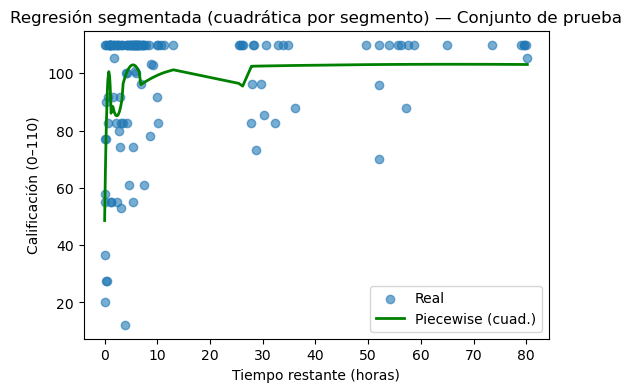

In [8]:
from mlinsights.mlmodel import PiecewiseRegressor

poly = PolynomialFeatures(degree=2, include_bias=True)
Xq_train = pd.DataFrame(poly.fit_transform(X_train)) 
Xq_test  = pd.DataFrame(poly.transform(X_test))
pw = PiecewiseRegressor('bins').fit(Xq_train.iloc[:, 1:], y_train)
yhat_seg = pw.predict(Xq_test.iloc[:, 1:])

rss = np.sum((y_test - yhat_seg) ** 2)
rse = np.sqrt(rss / max(len(y_test) - 2, 1))
print(f"RSS (prueba): {rss:.4f}")
print(f"RSE (prueba): {rse:.4f}")

order = np.argsort(X_test[:, 0])
xt = X_test[order, 0]
yt = y_test[order]
yh = yhat_seg[order]
plt.figure(figsize=(6,4))
plt.scatter(xt, yt, alpha=0.6, label="Real")
plt.plot(xt, yh, linewidth=2, color="green", label="Piecewise (cuad.)")
plt.xlabel("Tiempo restante (horas)")
plt.ylabel("Calificación (0–110)")
plt.title("Regresión segmentada — Conjunto de prueba")
plt.legend()
plt.show()

**5-**
 En este paso apliqué KNN para regresión con k=10 y ponderación por distancia, el modelo predice la calificación de cada caso de prueba como un promedio de sus 10 vecinos más cercanos en el conjunto de entrenamiento (dando más peso a los más próximos). Tras entrenar el KNN con fit, obtuve las predicciones (yhat_knn) y calculé su RSE en prueba para evaluar el error típico fuera de muestra. Para visualizarlo, en lugar de unir predicciones solo en los puntos de prueba (lo que genera zig-zags), construí un grid uniforme de tiempos dentro del rango observado y tracé la curva suavizada del modelo (plt.plot en morado) sobre la dispersión de valores reales; esta gráfica muestra cómo KNN aproxima la relación sin imponer una forma funcional específica, aunque su suavizado depende de la elección de k (valores mayores suavizan más y valores pequeños pueden sobreajustar).

RSE (KNN, k=10): 23.9902


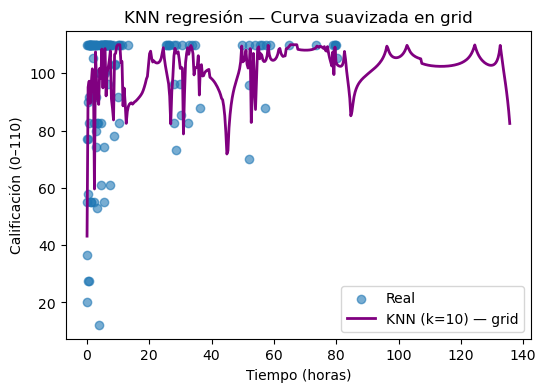

In [9]:
from sklearn.neighbors import KNeighborsRegressor

k = 10
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)

yhat_knn = knn.predict(X_test)

rss = np.sum((y_test - yhat_knn)**2)
rse_knn = np.sqrt(rss / max(len(y_test) - 2, 1))
print(f"RSE (KNN, k={k}): {rse_knn:.4f}")

order = np.argsort(X_test[:, 0])
xt = X_test[order, 0]
yt = y_test[order]
yh = yhat_knn[order]

xgrid = np.linspace(X_train.min(), X_train.max(), 400).reshape(-1,1)
ygrid = knn.predict(xgrid)

plt.figure(figsize=(6,4))
plt.scatter(X_test[:,0], y_test, alpha=0.6, label="Real")
plt.plot(xgrid[:,0], ygrid, linewidth=2, color="purple", label=f"KNN (k={k}) — grid")
plt.xlabel("Tiempo (horas)")
plt.ylabel("Calificación (0–110)")
plt.title("KNN regresión — Curva suavizada en grid")
plt.legend(); plt.show()

**6-**
 En este paso comparé el desempeño de los tres modelos aplicados (polinomial, segmentado y KNN) utilizando como métrica el RSE en el conjunto de prueba. Para ello definí una función rse que calcula el error típico a partir de la suma de cuadrados de los residuos (RSS). Con las predicciones de cada modelo (yhat_poly, yhat_seg, yhat_knn), obtuve su RSE correspondiente y lo imprimí en pantalla. Finalmente con los resultados, seleccioné cuál fue el modelo con el menor RSE, es decir, el que presentó mejor ajuste en validación. Esta comparación no solo permite identificar cuál tuvo menor error, sino también discutir que la métrica debe complementarse con criterios de interpretabilidad, aunque un modelo pueda tener el RSE más bajo, no siempre será el más sencillo de explicar o el más adecuado en la práctica.

In [30]:
def rse(y_true, y_pred):
    rss = np.sum((y_true - y_pred)**2)
    return np.sqrt(rss / max(len(y_true)-2, 1))

rse_poly = rse(y_test, yhat_poly)
rse_seg  = rse(y_test, yhat_seg)
rse_knn  = rse(y_test, yhat_knn)

print(f"RSE (Polinomial): {rse_poly:.4f}")
print(f"RSE (Segmentada): {rse_seg:.4f}")
print(f"RSE (KNN, k={k}): {rse_knn:.4f}")

resumen = {
    "Polinomial": rse_poly,
    "Segmentada": rse_seg,
    f"KNN (k={k})": rse_knn
}
mejor = min(resumen, key=resumen.get)
print(f"\nEl modelo con menor RSE fue: {mejor} (RSE={resumen[mejor]:.4f})")

RSE (Polinomial): 21.4854
RSE (Segmentada): 20.4683
RSE (KNN, k=10): 23.9902

El modelo con menor RSE fue: Segmentada (RSE=20.4683)


**7-**
 En este paso generé una gráfica conjunta para comparar los tres modelos en el conjunto de prueba. Los puntos azules representan los valores reales, mientras que las curvas muestran las predicciones: polinomial (naranja), segmentada (verde) y KNN (morado). Esta visualización permite ver de forma directa cómo cada modelo se ajusta a los datos y facilita contrastar sus comportamientos.

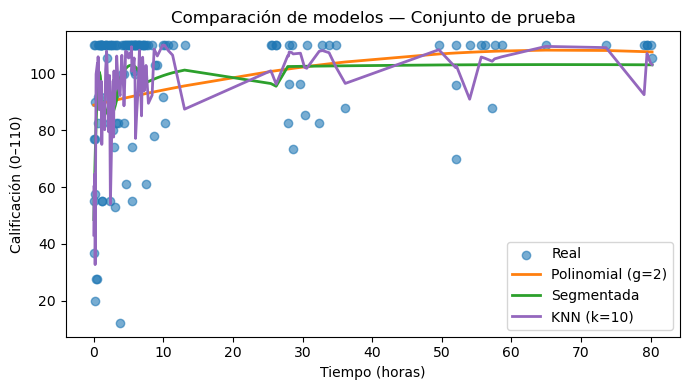

In [10]:
order = np.argsort(X_test[:, 0])
xt = X_test[order, 0]
yt = y_test[order]
yh_poly = yhat_poly[order]
yh_seg  = yhat_seg[order]
yh_knn  = yhat_knn[order]

plt.figure(figsize=(7,4))
plt.scatter(xt, yt, alpha=0.6, label="Real", color="tab:blue")
plt.plot(xt, yh_poly, linewidth=2, label="Polinomial (g=2)", color="tab:orange")
plt.plot(xt, yh_seg,  linewidth=2, label="Segmentada", color="tab:green")
plt.plot(xt, yh_knn,  linewidth=2, label=f"KNN (k={k})", color="tab:purple")

plt.xlabel("Tiempo (horas)")
plt.ylabel("Calificación (0–110)")
plt.title("Comparación de modelos — Conjunto de prueba")
plt.legend()
plt.tight_layout()
plt.show()

En conclusión el modelo segmentado resulta el más conveniente, porque logra el mejor equilibrio entre bajo error (RSE más bajo) y capacidad de adaptarse a los datos. No obstante, si la prioridad fuera la interpretabilidad (explicar con una sola fórmula sencilla), la regresión polinomial también sería una alternativa válida, aunque con un error ligeramente mayor.